# Testing automatic fiducial finding

We want to automatically find fiducials and spit out an ANC file for work with peak selector

In [1]:
%matplotlib inline
import pandas as pd
import tqdm
import numpy as np
from skimage.filters import threshold_otsu
%load_ext autoreload
%autoreload 2
import palm_utils as pu
from peaks.peakfinder import PeakFinder

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm

In [3]:
data_single = pu.PALMData("20170725_Run1_532_slab0_singlebead_IDL.sav")
data_old = pu.PALMData("20170725_Run1_532_slab0_manybeads_old_IDL.sav")
data_new = pu.PALMData("20170725_Run1_532_slab0_manybeads_new_IDL.sav")

Reading 20170725_Run1_532_slab0_singlebead_IDL.sav into memory ... 


C:\Anaconda3\lib\site-packages\scipy\io\idl.py:473: UserWarning: Using experimental 64-bit array read
  warnings.warn("Using experimental 64-bit array read")


--------------------------------------------------
Date: Tue Aug 15 14:09:45 2017
User: hoffmand
Host: h10u31.int.janelia.org
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.5.1
--------------------------------------------------
Successfully read 32 records of which:
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
 - 29 are of type VARIABLE
--------------------------------------------------
Available variables:
 - cgroupparams [<class 'numpy.ndarray'>]
 - grouping_gap [<class 'numpy.int16'>]
 - cgrpsize [<class 'numpy.int32'>]
 - z_unwrap_coeff [<class 'numpy.ndarray'>]
 - paramlimits [<class 'numpy.ndarray'>]
 - cal_lookup_data [<class 'numpy.ndarray'>]
 - image [<class 'numpy.ndarray'>]
 - thisfitcond [<class 'numpy.recarray'>]
 - pkwidth_offset [<class 'numpy.float32'>]
 - nd_oil [<class 'numpy.float32'>]
 - fiducialcoeff [<class 'numpy.recarray'>]
 - nmperframe [<class 'numpy.float32'>]
 - ellipticity_slo

In [4]:
def find_fiducials(df, yx_shape, subsampling=1, thresh=None):
    """Find fiducials in pointilist PALM data
    
    The key here is to realize that there should be on fiducial per frame"""
    # incase we subsample the frame number
    num_frames = df.framenum.max() - df.framenum.min()
    bins = [np.arange(s + subsampling, step=subsampling) - subsampling / 2 for s in yx_shape]
    # ungrouped 2d histogram to find peaks, ungrouped to make beads really stand out
    hist_2d = np.histogramdd(df[["ypos", "xpos"]].values, bins=bins)[0]
    pf = PeakFinder(hist_2d, 1)
    # set the thresh to 1/10th of the number of frames (if this doesn't work drift is really bad)
#     pf.thresh = num_frames * min(subsampling, 1) * 0.12 
    # the 0.12 factor is for the DoG filter for blob finding.
    pf.blob_sigma = 1/subsampling
    # no blobs found so try again with a lower threshold
    pf.thresh = 0
    pf.find_blobs()
    blob_thresh = max(threshold_otsu(pf.blobs[:, 3]), num_frames / 10)
    if not pf.blobs.size:
        # still no blobs then raise error
        raise RuntimeError("No blobs found!")
    pf.blobs = pf.blobs[pf.blobs[:,3] > blob_thresh]
#     pf.plot_blobs(cmap="inferno", norm=PowerNorm(0.5))
    if pf.blobs[:, 3].max() < num_frames * subsampling / 2:
        print("Warning, drift maybe too high to find fiducials")
    # correct positions for subsampling
    pf.blobs[:, :2] = pf.blobs[:, :2] * subsampling
    return pf.blobs

# Refining

We can see that we pick too many fiducials above, we should drift correct and then test again

In [18]:
def remove_xy_mean(df):
    df_mean = df[["ypos", "xpos"]].astype(np.float).mean()
    df_new = df.copy()
    df_new[["ypos", "xpos"]] -= df_mean
    return df_new

def calc_drift(fiducials_df, weighted="amp", diagnostics=False):
    """"""
    mean_removed = [remove_xy_mean(ff) for ff in fiducials_df]
    if diagnostics:
        fig, (ax0, ax1) = plt.subplots(1, 2)
        for ff in mean_removed:
            ff.xpos.plot(ax=ax0)
            ff.ypos.plot(ax=ax1)
            
    # want to do a weighted average
    # need to reset_index after concatination so that all localzations have unique ID
    df_means = pd.concat(mean_removed).reset_index()

    # Define a dictionary with the functions to apply for a given column:
    if weighted:
        wm = lambda group: np.average(group, weights=df_means.loc[group.index, weighted])
    else:
        wm = "mean"
    return df_means.groupby("framenum").agg({"xpos" : wm, "ypos" : wm, "zpos" : wm})

In [54]:
2 * np.sqrt(2 * np.log(2))

2.3548200450309493

In [61]:
520/1.33/(1-np.cos(np.arcsin(0.85/1.33)))

1693.4632706793752

In [62]:
520/(1.33-np.sqrt(1.33**2 - 0.85**2)) / (520 / 2 / 0.85)

5.5363222310671887

In [27]:
def calc_fiducial_stats(fid_df_list):
    """Calculate various stats"""
    fwhm = lambda x: x.std() * 2 * np.sqrt(2 * np.log(2))
    fid_stats = pd.DataFrame([f[["xpos", "ypos","zpos", "amp"]].mean() for f in fid_df_list])
    fid_stats[["xdrift", "ydrift", "zdrift"]] = pd.DataFrame([f.agg({"xpos":fwhm,"ypos":fwhm, "zpos":fwhm}) for
                                                    f in fid_df_list])[["xpos","ypos", "zpos"]]
    fid_stats["sigma"] = np.sqrt(fid_stats.ydrift**2 + fid_stats.xdrift**2)
    all_drift = pd.concat([f[["xpos","ypos", "zpos"]] - f[["xpos","ypos", "zpos"]].mean() for f in fid_df_list])
    return fid_stats, all_drift

def extract_fiducials(df, blobs, radius, min_num_frames=0):
    """Do the actual filtering
    
    We're doing it sequentially because we may run out of memory.
    If initial DataFrame is 18 GB (1 GB per column) and we have 200 """
    fiducials_dfs = [df[np.sqrt((df.xpos - x) ** 2 + (df.ypos - y) ** 2) < radius]
        for y, x in tqdm.tqdm_notebook(blobs, leave=False, desc="Extracting Fiducials")]
    # remove any duplicates in a given frame by only keeping the localization with the largest count
    clean_fiducials = [sub_df.sort_values('amp', ascending=False).groupby('framenum').first()
                       for sub_df in fiducials_dfs if len(sub_df) > min_num_frames]
    return clean_fiducials

In [152]:
def plot_stats(fids_df):
    fid, drift = calc_fiducial_stats(fids_df)
    drift[["xpos","ypos"]] *= 130
    fid[["xpos", "xdrift", "ypos", "ydrift", "sigma"]] *= 130
    fid.sort_values("sigma").reset_index().plot(subplots=True)
    fid.hist(bins=32)
    drift.hist(bins=64, normed=True, layout=(3,1), figsize=(3, 9))
#     pd.plotting.table(plt.gca(), np.round(drift.describe(), 2), loc='upper right', colWidths=[0.2, 0.2, 0.2])
    print(drift.std() * 2 * np.sqrt(2 * np.log(2)))

In [31]:
potential_fids_loc = find_fiducials(data_single.processed, (512, 512))

In [ ]:
fids_single_df = extract_fiducials(data_single.processed, potential_fids_loc[:,:2], 2)

xpos     33.541490
ypos     43.920329
zpos    433.745839
dtype: float64


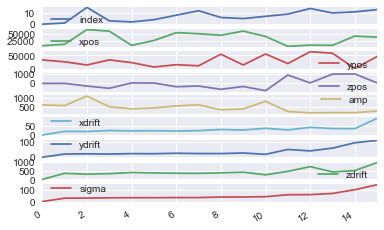

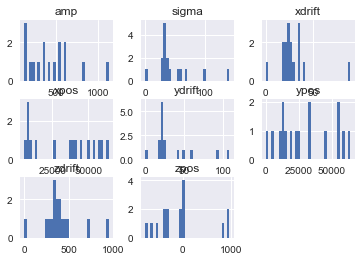

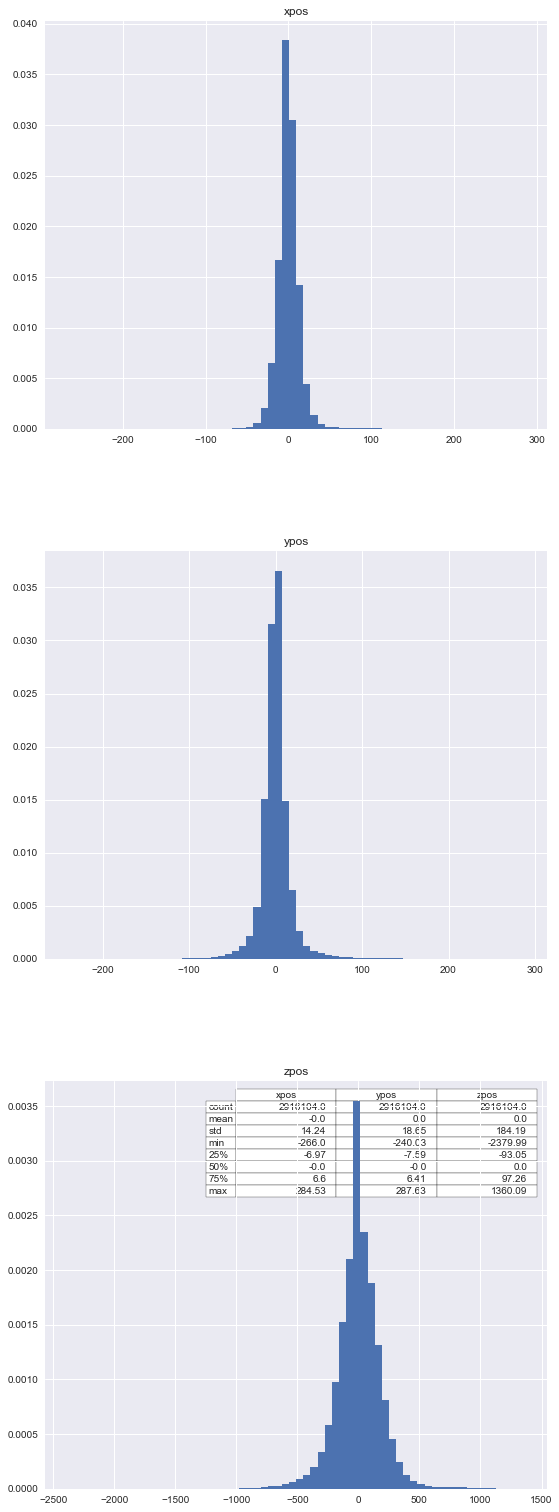

In [139]:
plot_stats(fids_single_df)

In [44]:
fid, drift = calc_fiducial_stats(fids_single_df)
good_fids = fid[fid.sigma < 50/130][["ypos", "xpos"]].values

In [47]:
fid.sigma.std()

0.2542729629137088

In [140]:
fids_single_df = extract_fiducials(data_single.processed, good_fids, 2)
fids_old_df = extract_fiducials(data_old.processed, good_fids, 2)
fids_new_df = extract_fiducials(data_new.processed, good_fids, 2)

xpos     23.826058
ypos     21.713810
zpos    328.866435
dtype: float64
xpos     21.438425
ypos     19.338911
zpos    318.732433
dtype: float64
xpos     18.460248
ypos     16.106241
zpos    243.045437
dtype: float64


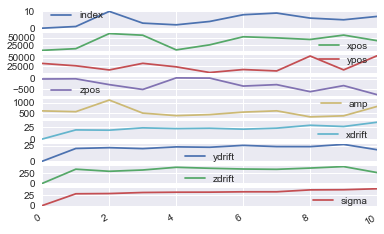

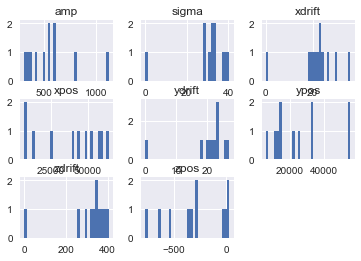

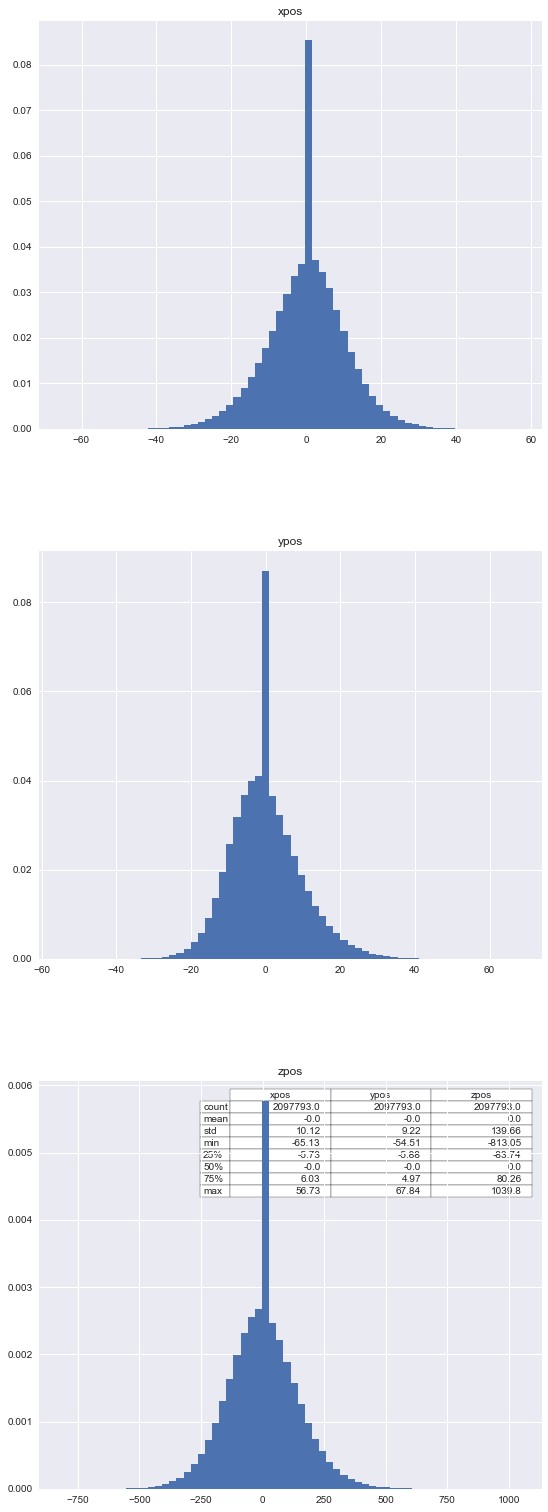

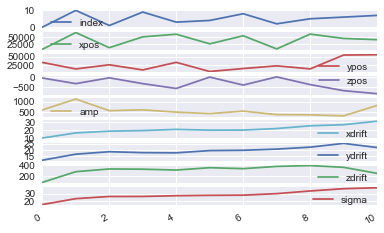

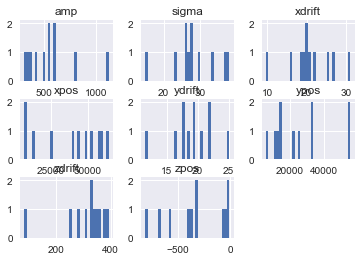

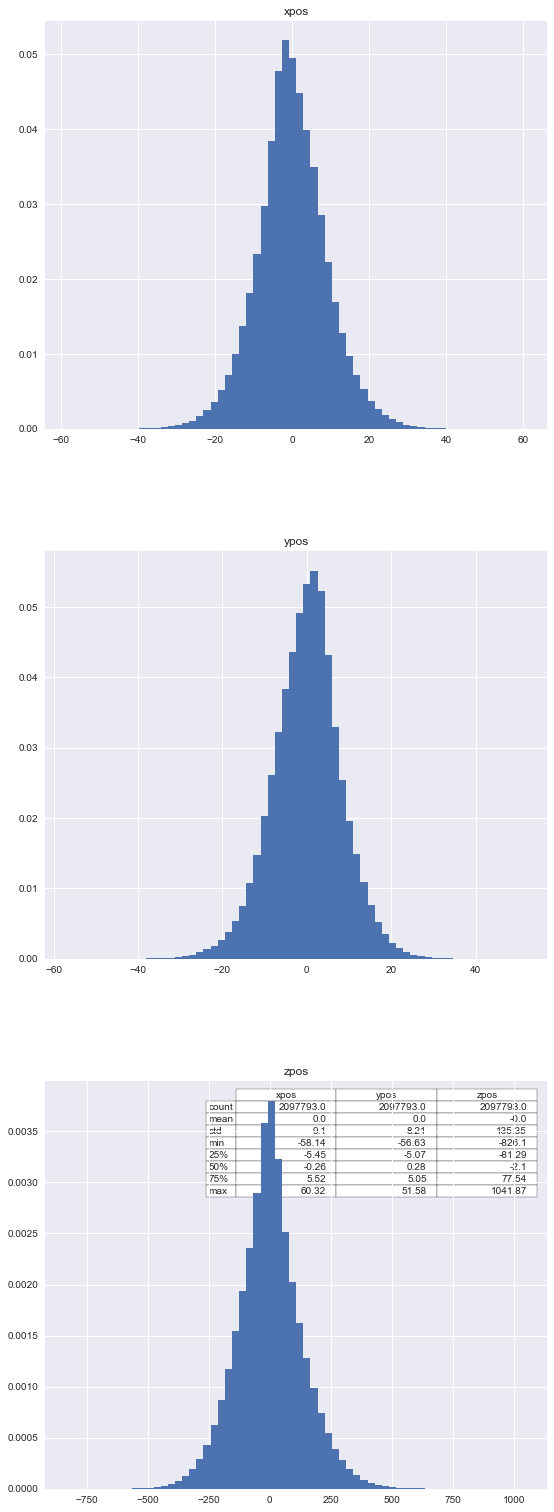

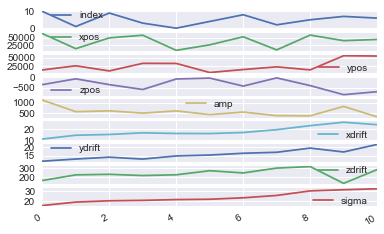

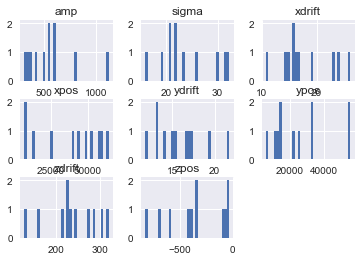

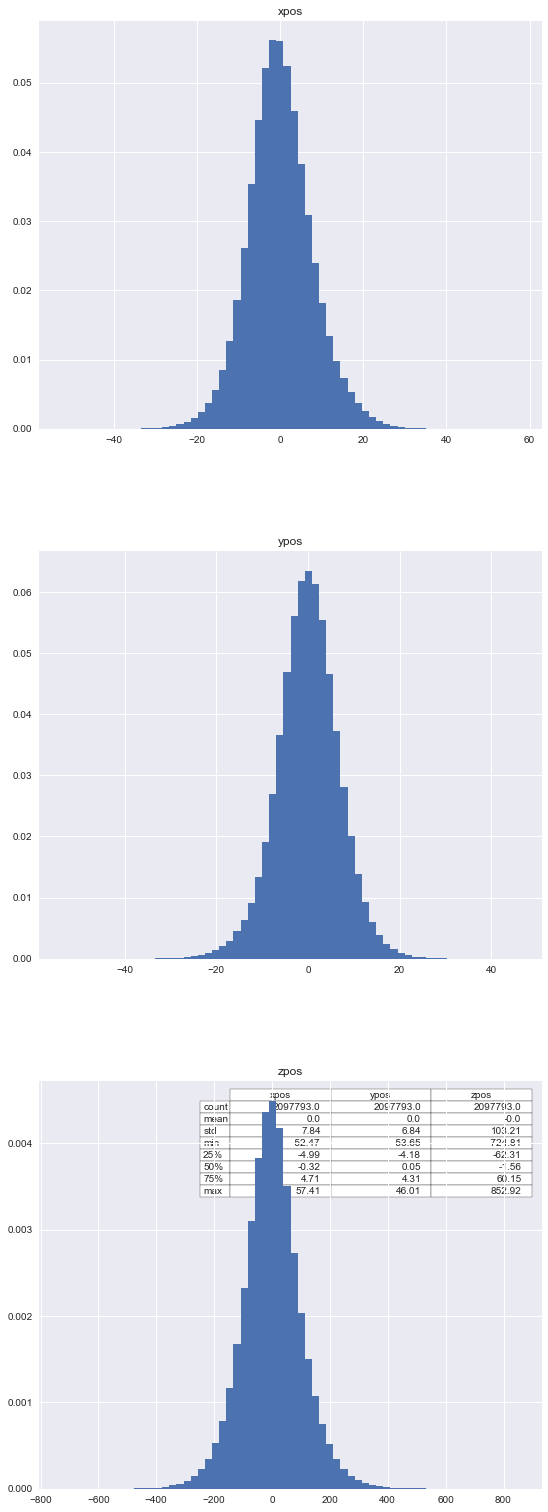

In [141]:
plot_stats(fids_single_df)
plot_stats(fids_old_df)
plot_stats(fids_new_df)

In [142]:
def drift_correct(df_data, fids, radius, min_num_frames=0):
    fids_df = extract_fiducials(df_data, fids, radius, min_num_frames=0)
    drift_mean = calc_drift(fids_df, False)
    drift_mean.plot(subplots=True)
    df_data_dc = df_data.set_index("framenum")
    df_data_dc[["xpos", "ypos", "zpos"]] -= drift_mean
    return df_data_dc.reset_index(), drift_mean, fids_df

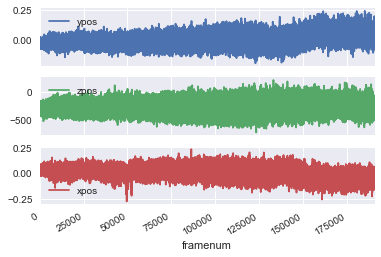

In [143]:
data_single_dc, data_single_drift, data_single_fids = drift_correct(data_single.processed, good_fids, 2)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001A1625A9438>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x000001A1607C5668>], dtype=object)

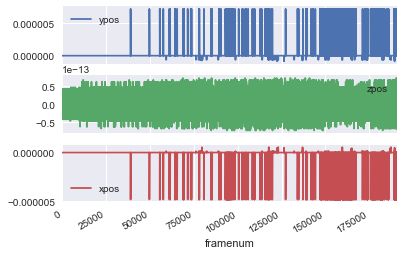

In [144]:
data_single_fids_dc = extract_fiducials(data_single_dc, good_fids, 2)
drift_mean = calc_drift(data_single_fids_dc, False)
drift_mean.plot(subplots=True)

xpos     18.207835
ypos     15.911420
zpos    240.098656
dtype: float64


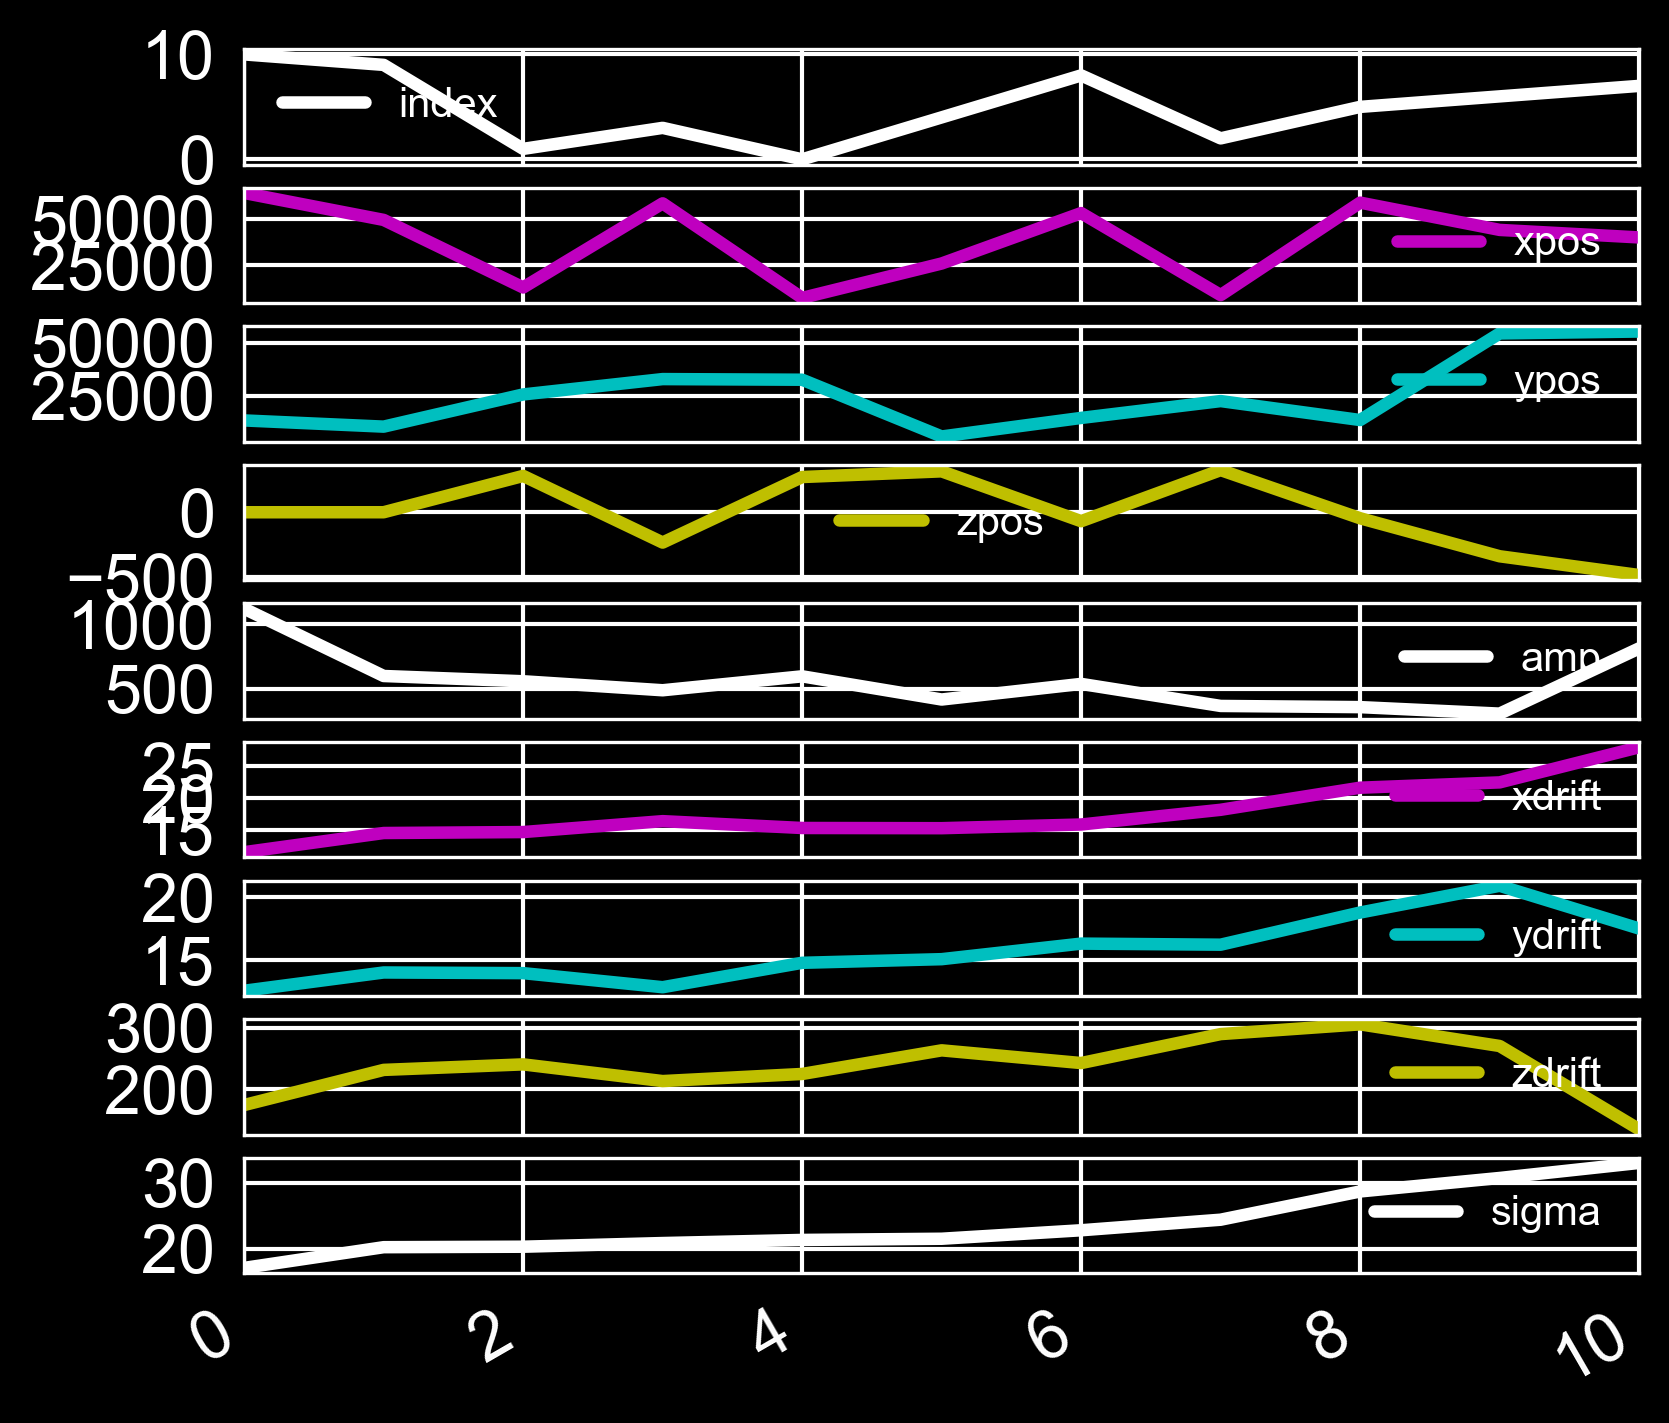

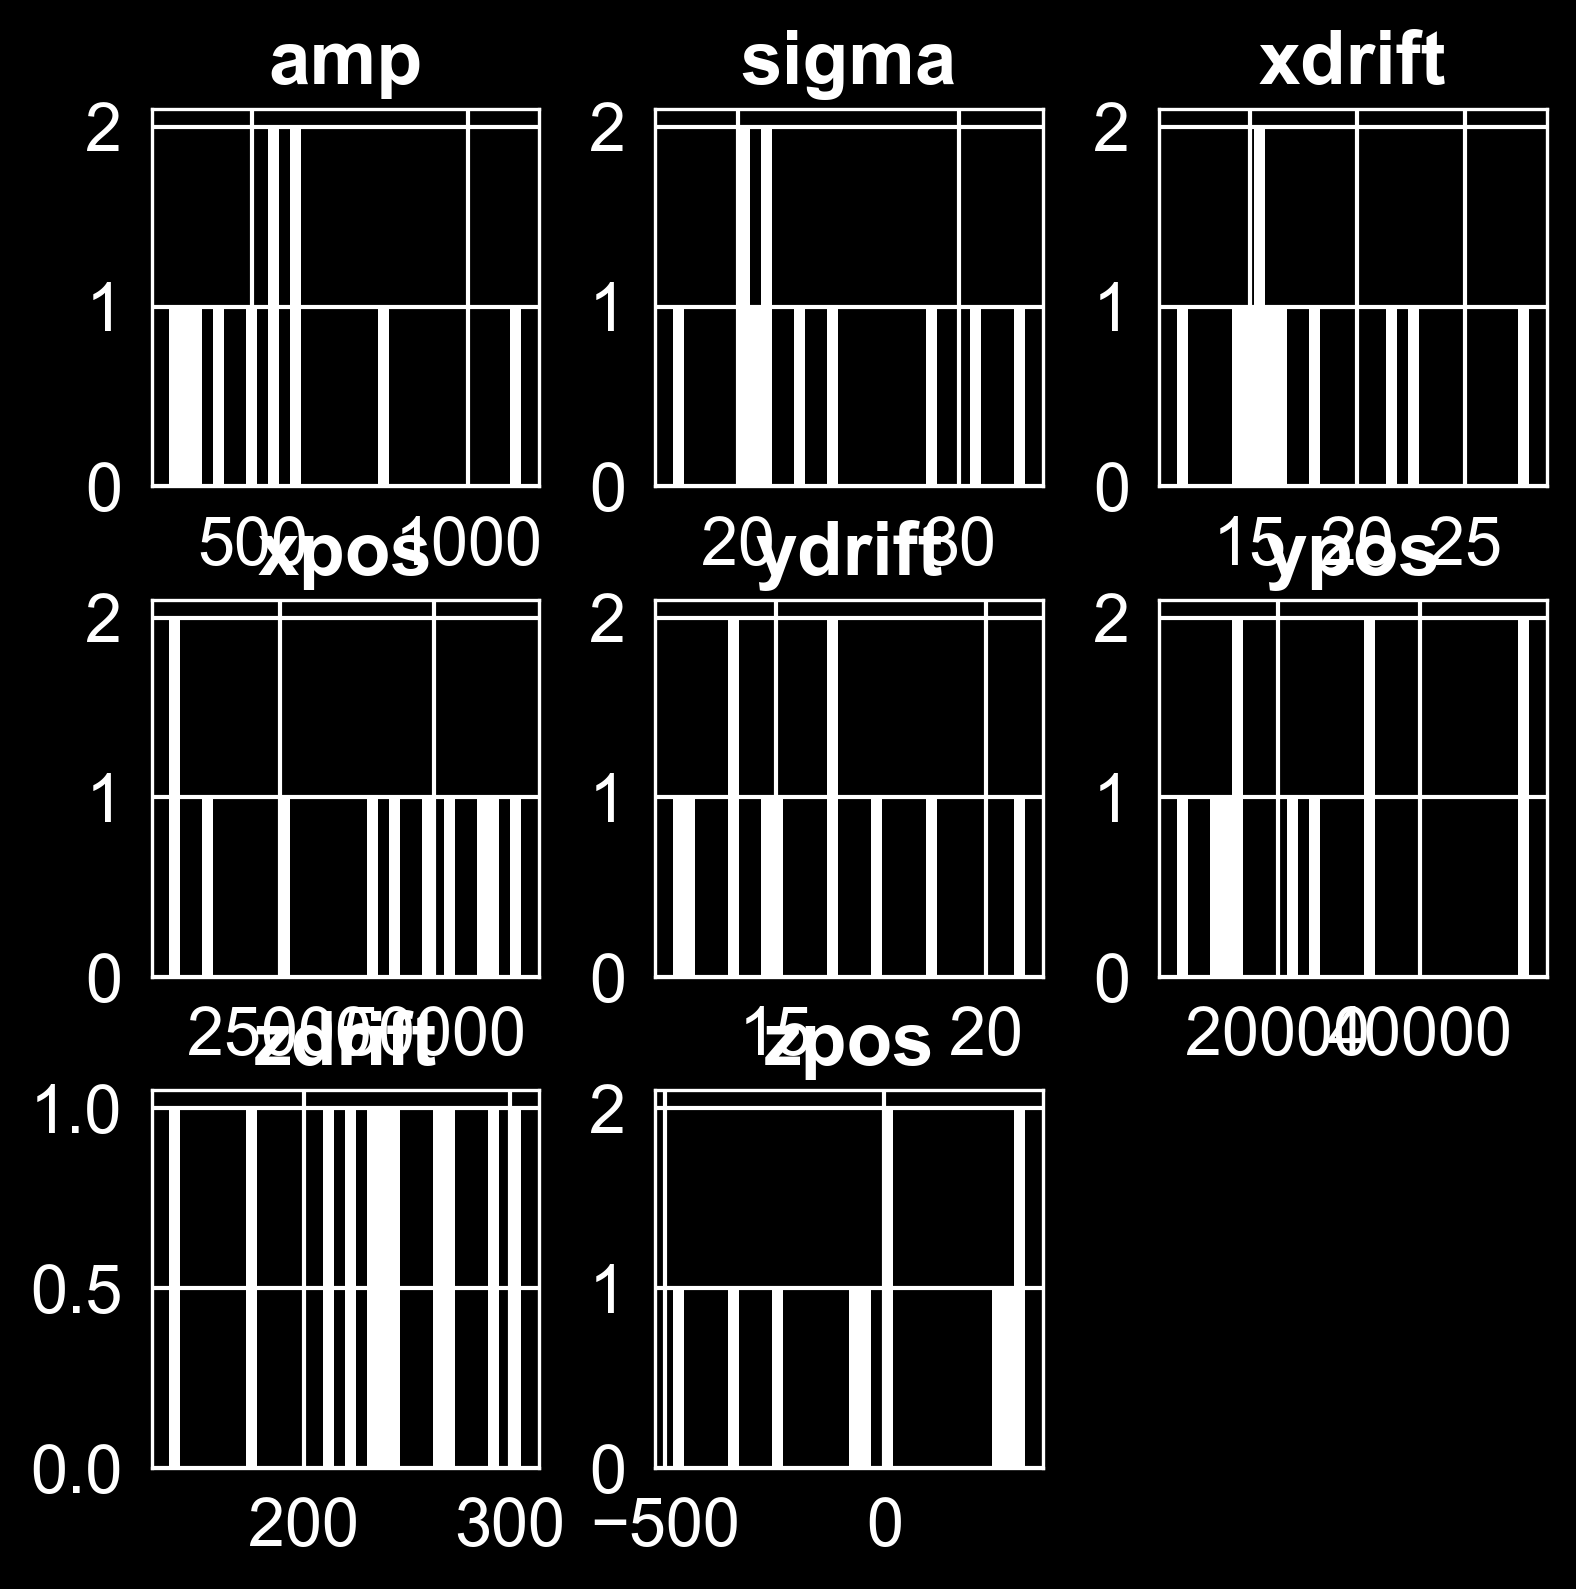

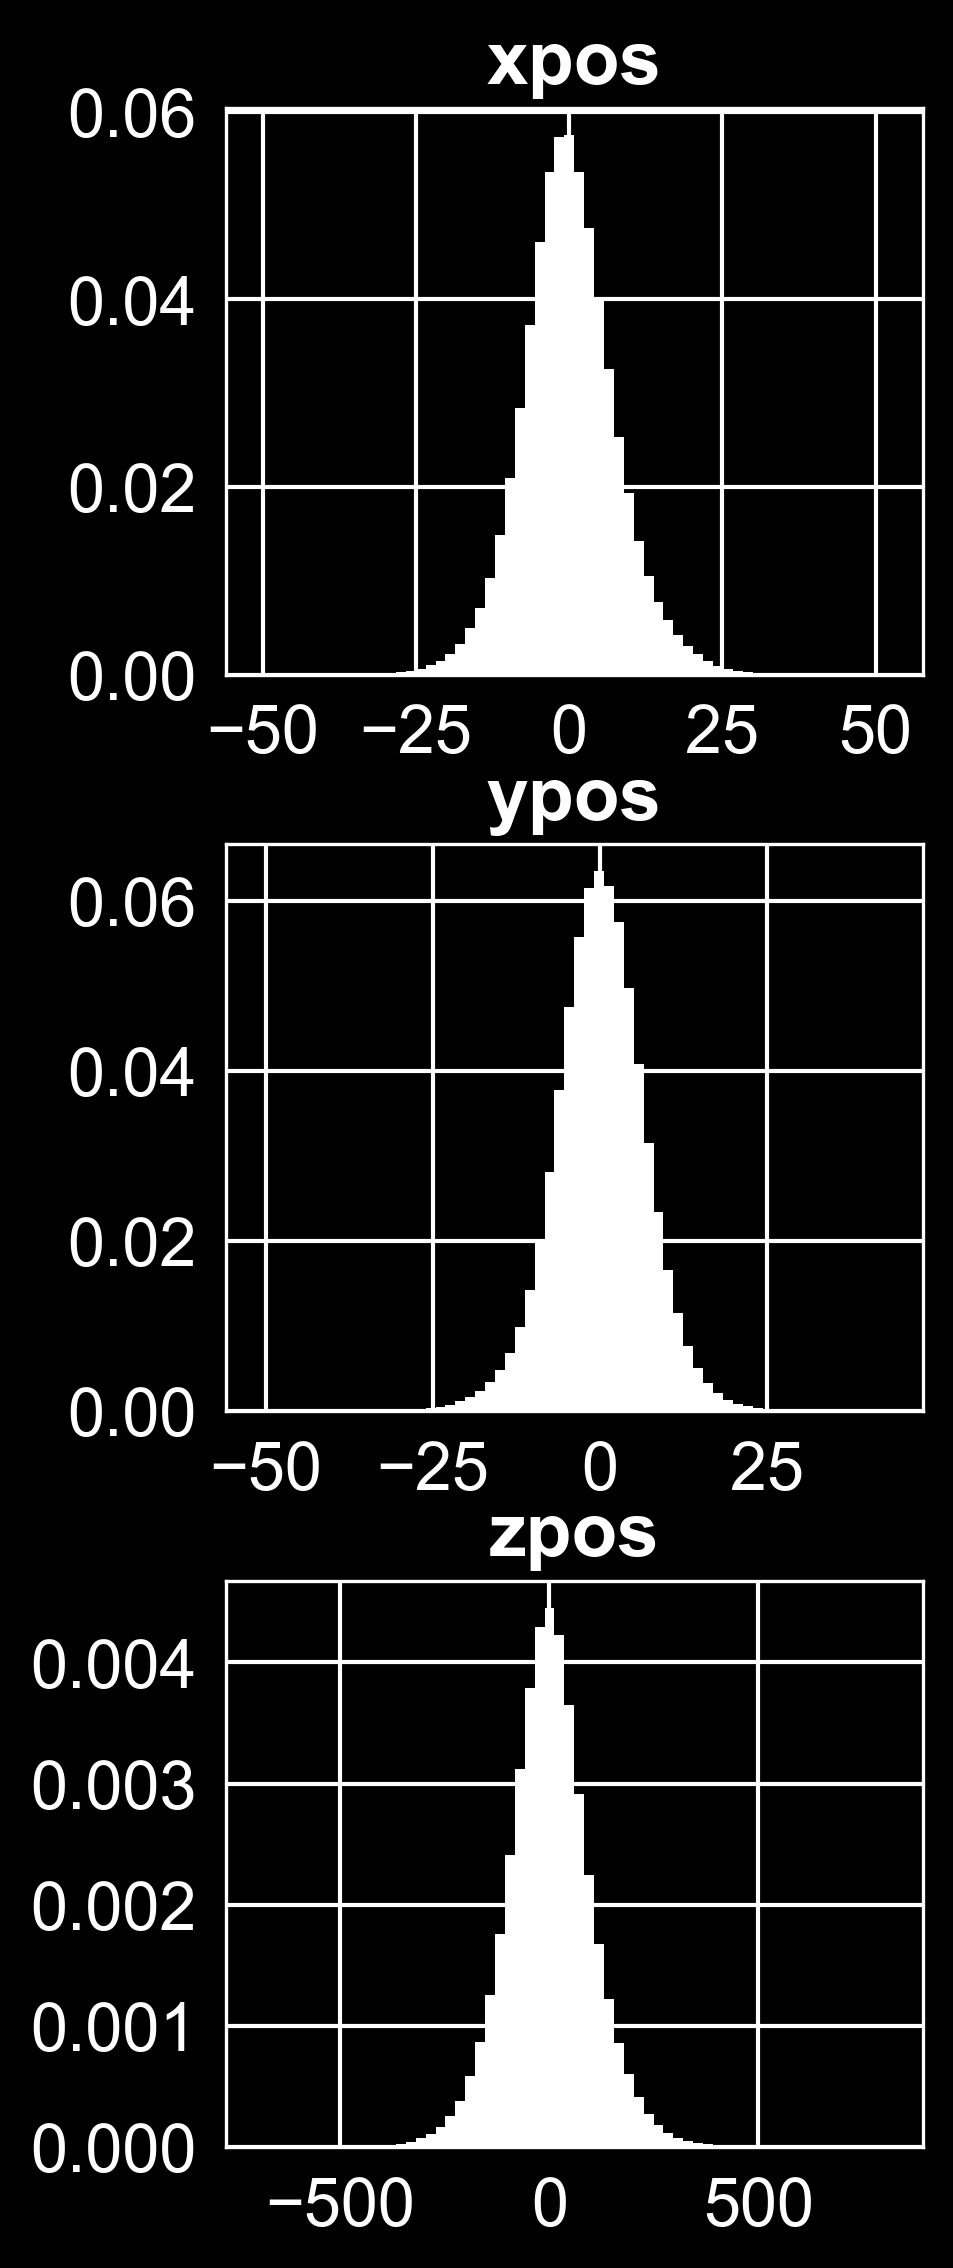

In [153]:
with plt.style.context("dph_presentation"):
    plot_stats(data_single_fids_dc)

xpos    380.524136
ypos     79.962678
dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A170798DA0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001A0F10C31D0>]], dtype=object)

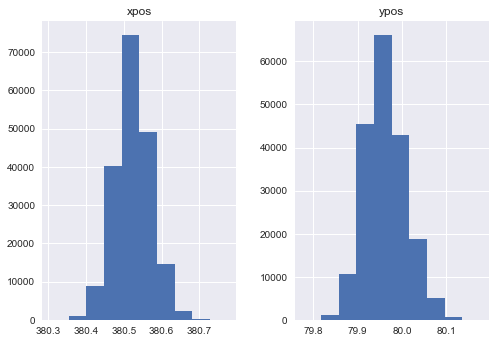

In [102]:
print(data_single_fids_dc[-2][["xpos","ypos"]].mean())
(data_single_fids_dc[-2][["xpos","ypos"]].hist())

In [107]:
%matplotlib inline

In [116]:
import skimage.external.tifffile as tif

In [121]:
hist2d = np.histogramdd(data_single_dc[["ypos", "xpos"]].values, bins=(np.arange(0,512+0.1, .1) - 0.05,)*2)
tif.imsave("junk.tif", hist2d[0].astype(np.uint32))

In [120]:
hist2d[0].max() < 2**16

False

(0.0, 512.0, 512.0, 0.0)

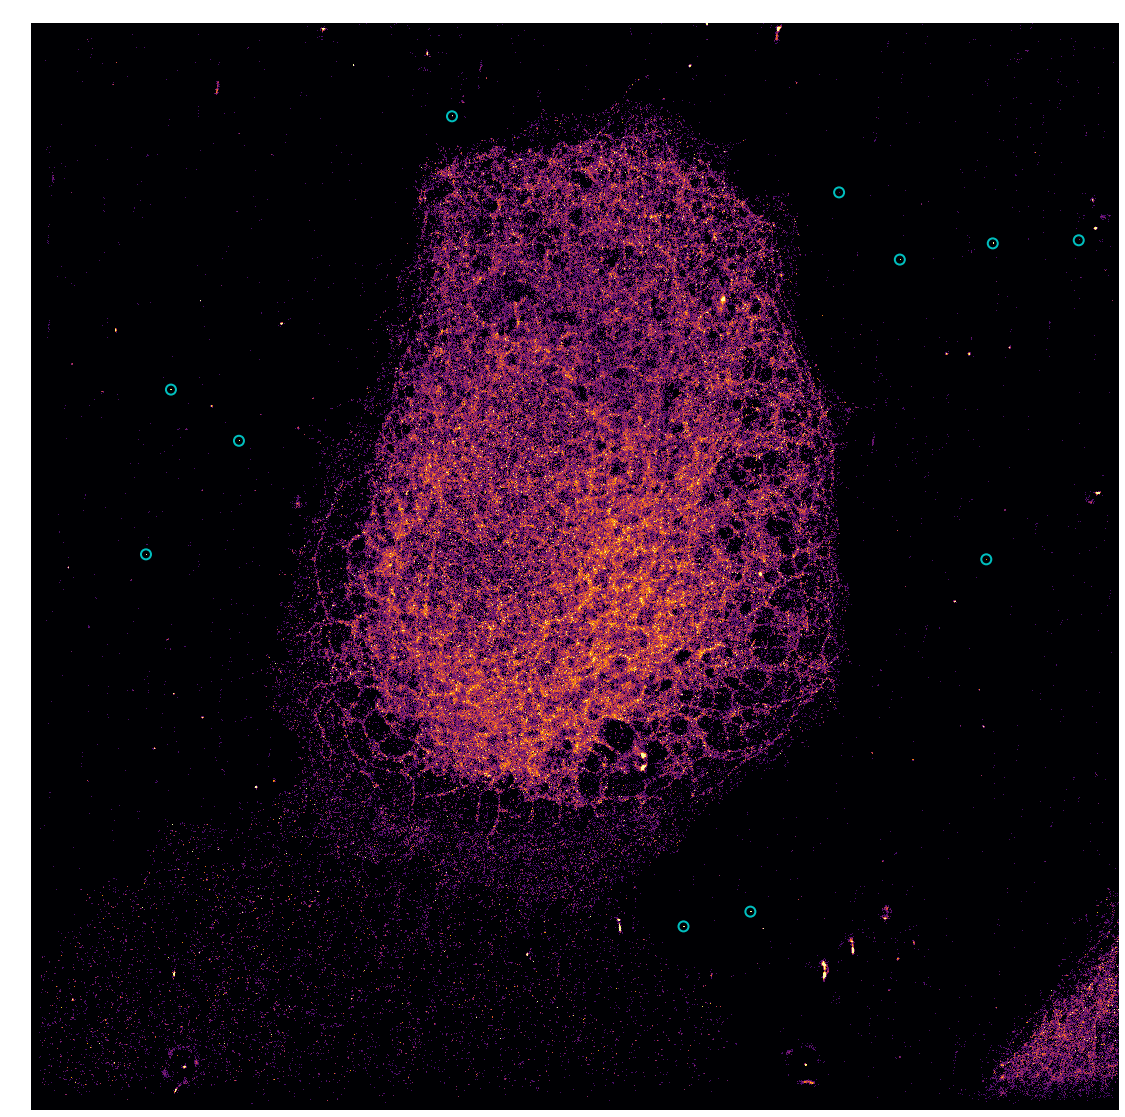

In [149]:
fig, ax = plt.subplots(figsize=(20,20))
ax.matshow(hist2d[0], norm=PowerNorm(0.5), cmap="inferno", vmax=20, extent=(0, 512, 512, 0))
ax.grid("off")
ax.scatter(good_fids[:,1], good_fids[:,0], 100, facecolors='none', edgecolors='c', linewidths=2)
ax.axis("off")